**Animal Performance on W-Track** 

**Set up**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sys import argv
import matplotlib.pyplot as pyplot
import matplotlib.ticker as plt_ticker

In [ ]:
#base_name = '20230531_154845' #'20230531_150338'
#data_directory = f'/home/zoldello/Documents/data/L5/r2/{base_name}/'
#  L5/20230502/r2



base_name = '20230502_163824'
data_directory = f'/home/phil/Documents/Data/20230502/r2/20230502_163824'

dio_directory = f'{base_name}.DIO'
time_directory = f'{base_name}.time'
# trodes_directory = '/home/zoldello/Apps/Trodes_2-4-0_Ubuntu2004/'
trodes_directory =  ' /home/phil/Apps/Trodes_2-4-0_Ubuntu2004/'
dio_path = f'{data_directory}/{dio_directory}/{base_name}'

full_file_path = f'{data_directory}/{base_name}.rec'
trodesexport_runner = f'{trodes_directory}trodesexport'

In [ ]:
!$trodesexport_runner -rec {full_file_path} -dio -time

**Trodes' Functions**

In [ ]:
# Main function
def readTrodesExtractedDataFile(filename):
    with open(filename, 'rb') as f:
        # Check if first line is start of settings block
        if f.readline().decode('ascii').strip() != '<Start settings>':
            raise Exception("Settings format not supported")
        fields = True
        fieldsText = {}
        for line in f:
            # Read through block of settings
            if(fields):
                line = line.decode('ascii').strip()
                # filling in fields dict
                if line != '<End settings>':
                    vals = line.split(': ')
                    fieldsText.update({vals[0].lower(): vals[1]})
                # End of settings block, signal end of fields
                else:
                    fields = False
                    dt = parseFields(fieldsText['fields'])
                    fieldsText['data'] = np.zeros([1], dtype = dt)
                    break
        # Reads rest of file at once, using dtype format generated by parseFields()
        dt = parseFields(fieldsText['fields'])
        data = np.fromfile(f, dt)
        fieldsText.update({'data': data})
        return fieldsText


# Parses last fields parameter (<time uint32><...>) as a single string
# Assumes it is formatted as <name number * type> or <name type>
# Returns: np.dtype
def parseFields(fieldstr):
    # Returns np.dtype from field string
    sep = re.split('\s', re.sub(r"\>\<|\>|\<", ' ', fieldstr).strip())
    # print(sep)
    typearr = []
    # Every two elmts is fieldname followed by datatype
    for i in range(0,sep.__len__(), 2):
        fieldname = sep[i]
        repeats = 1
        ftype = 'uint32'
        # Finds if a <num>* is included in datatype
        if sep[i+1].__contains__('*'):
            temptypes = re.split('\*', sep[i+1])
            # Results in the correct assignment, whether str is num*dtype or dtype*num
            ftype = temptypes[temptypes[0].isdigit()]
            repeats = int(temptypes[temptypes[1].isdigit()])
        else:
            ftype = sep[i+1]
        try:
            fieldtype = getattr(np, ftype)
        except AttributeError:
            print(ftype + " is not a valid field type.\n")
            exit(1)
        else:
            typearr.append((str(fieldname), fieldtype, repeats))
    return np.dtype(typearr)

**Time**

In [ ]:
times_dat = readTrodesExtractedDataFile(f'{data_directory}/{time_directory}/{base_name}.timestamps.dat')
#time = readTrodesExtractedDataFile(f'/stelmo/kyu/L5/20230502/r2/20230502_163824/20230502_163824.time/20230502_163824.timestamps.dat')

In [ ]:
trodes_ptp_time_map = pd.DataFrame({
    'trodes_time': times_dat['data']['time'],
    'ptp': times_dat['data']['systime']
}, columns=['trodes_time', 'ptp'])

**Functions**

In [ ]:
def convert_trode_time_list_to_ptp(trodes_times):
    trodes_ptp_time_map0 = trodes_ptp_time_map.iloc[0]['ptp']
    return np.array([
        (trodes_ptp_time_map[trodes_ptp_time_map['trodes_time']==tt]['ptp'].values[0] - trodes_ptp_time_map0) / pow(10, 9)
            if len(trodes_ptp_time_map[trodes_ptp_time_map['trodes_time']==tt]['ptp']) > 0
            else 0
        for tt in trodes_times.tolist()
    ])

In [ ]:
def separate_reward_by_state(poke_rewards):
    rewarded_poke_rewards_time = [];
    rewarded_poke_rewards_state = [];
    non_rewarded_poke_rewards_time = [];
    non_rewarded_poke_rewards_state = [];
    reward_times = poke_rewards['time']
    reward_states = poke_rewards['reward_state']
    for i, reward_state in np.ndenumerate(reward_states):
        index = i[0]
        if reward_state == 0:
            non_rewarded_poke_rewards_state.append(reward_state)
            non_rewarded_poke_rewards_time.append(reward_times[index])
        else:
            rewarded_poke_rewards_state.append(reward_state)
            rewarded_poke_rewards_time.append(reward_times[index])

    return (
            np.array(rewarded_poke_rewards_state),
            np.array(rewarded_poke_rewards_time),
            np.array(non_rewarded_poke_rewards_state),
            np.array(non_rewarded_poke_rewards_time),
     )

In [ ]:
def performance_in_track(poke_and_reward):
    reward = poke_and_reward['reward_state']
    reward_sum = len(reward)
    reward_gained = len(reward[reward == 1])
    reward_missed = len(reward[reward == 0])
    accuracy = reward_gained/reward_sum
    return accuracy

**Dins Dat**

In [ ]:
din1_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din1.dat')
din2_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din2.dat')
din7_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din7.dat')

**Dout Dat**

In [ ]:
dout4_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout4.dat')
dout5_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout5.dat')
dout6_dat = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout6.dat')

**Din**

In [ ]:
din1 = pd.DataFrame({
    'reward_state': din1_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(din1_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

din2 = pd.DataFrame({
    'reward_state': din2_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(din2_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

din7 = pd.DataFrame({
    'reward_state': din7_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(din7_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

**Dout**

In [ ]:
dout4 = pd.DataFrame({
    'reward_state': dout4_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(dout4_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

dout5 = pd.DataFrame({
    'reward_state': dout5_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(dout5_dat['data']['time'])
}, columns=['reward_state', 'ptp'])

dout6 = pd.DataFrame({
    'reward_state': dout6_dat['data']['state'], 
    'ptp': convert_trode_time_list_to_ptp(dout6_dat['data']['time'])
}, columns=['reward_state', 'ptp'])


**Get Poke and Reward Map**

In [ ]:
def map_poke_and_reward(din, dout):
    din_length = len(din)
    rat_time_at_reward_well = 13
    delay = 0.1
    din_index = 0
    poke_and_reward = {
        'reward_state': [],
        'time': []
    }
    
    while din_index < din_length - 1:
        current_din_time = din.iloc[din_index]['ptp'] 
        
        if current_din_time == 0:
            din_index += 1
            continue
#         skip_loop = (
#             din_index % 2 == 1
#              #or current_din_time == 0.0
#         )
        
#         if skip_loop:
#             din_index += 1
#             continue
        
#         ####
#         #print(current_din_time)
#         ####
        
        din_index_next_1 = din_index
        din_index_next_2 = din_index + 1
        while din_index_next_2 < din_length and din_index_next_1 < din_length:
            din_diff = din.iloc[din_index_next_2]['ptp'] - din.iloc[din_index_next_1]['ptp']
            if din_diff < rat_time_at_reward_well:
                din_index_next_1 += 1
                din_index_next_2 += 1
                continue
            break

        din_index = din_index_next_2
                
        data_query = f'ptp > {current_din_time} and ptp < {current_din_time + rat_time_at_reward_well}'
        dout_data = dout.query(data_query)
        dout_data_length = len(dout_data)
        reward_state = 1 if dout_data_length > 0 and dout_data['reward_state'].sum() > 0 else 0

        poke_and_reward['reward_state'].append(reward_state)
        poke_and_reward['time'].append(current_din_time)
      
#         data_query = f'ptp >= {current_din_time - delay} and ptp < {current_din_time + rat_time_at_reward_well}'
#         din_data = din.query(data_query)
#         din_data_length = len(din_data)
        
#         if din_data_length == 0:
#             din_index += 1
#             continue
        
#         dout_data = dout.query(data_query)
#         dout_data_length = len(dout_data)
#         reward_state = 1 if dout_data_length > 0 and dout_data['reward_state'].sum() > 0 else 0
#         poke_and_reward['reward_state'].append(reward_state)
#         poke_and_reward['time'].append(current_din_time)
#         din_index = din_data.index[din_data_length - 1] + 1
        
        
    return {
        'reward_state': np.array(poke_and_reward['reward_state']),
        'time': np.array(poke_and_reward['time'])
    }

In [ ]:
din2[0:30]

In [ ]:
####
#poke_and_reward_1 = map_poke_and_reward(din1, dout4)
#print(poke_and_reward_1)

#print(din1[0:30])
#print(dout4)
#dout4_dat['data']
print(map_poke_and_reward(din2, dout5))
print(dout5)

**Poke and Rewards**

In [ ]:
poke_and_reward_1 = map_poke_and_reward(din1, dout4)
poke_and_reward_2 = map_poke_and_reward(din2, dout5)
poke_and_reward_7 = map_poke_and_reward(din7, dout6)

In [ ]:
###
#print(poke_and_reward_2)
print(din2[0:50])
print('\n')
print(dout5)

In [ ]:
###
dout

In [ ]:
####
dout4[dout4['reward_state'] == 0]

**Poke/Reward splitting**

In [ ]:
(rewarded_poke_rewards_state_1,
rewarded_poke_rewards_time_1,
non_rewarded_poke_rewards_state_1,
non_rewarded_poke_rewards_time_1) = separate_reward_by_state(poke_and_reward_1)

(rewarded_poke_rewards_state_2,
rewarded_poke_rewards_time_2,
non_rewarded_poke_rewards_state_2,
non_rewarded_poke_rewards_time_2) = separate_reward_by_state(poke_and_reward_2)

(rewarded_poke_rewards_state_7,
rewarded_poke_rewards_time_7,
non_rewarded_poke_rewards_state_7,
non_rewarded_poke_rewards_time_7) = separate_reward_by_state(poke_and_reward_7)

**Plots**

In [ ]:
from numpy import *
import math
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20,3))
#ax = plt.axes()
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Left', 'Center', 'Right'])

plt.scatter(rewarded_poke_rewards_time_7, rewarded_poke_rewards_state_7+1, edgecolor='g', facecolor='g') # plotting t, a separately 
plt.scatter(rewarded_poke_rewards_time_2,  rewarded_poke_rewards_state_2, edgecolor='r', facecolor='r') # plotting t, b separately 
plt.scatter(rewarded_poke_rewards_time_1,  rewarded_poke_rewards_state_1-1, edgecolor='b', facecolor='b') # plotting t, c separately


plt.scatter(non_rewarded_poke_rewards_time_7, non_rewarded_poke_rewards_state_7 + 1+1, edgecolor='g', facecolor='none') # plotting t, a separately 
plt.scatter(non_rewarded_poke_rewards_time_2, non_rewarded_poke_rewards_state_2 + 1, edgecolor='r', facecolor='none') # plotting t, b separately 
plt.scatter(non_rewarded_poke_rewards_time_1 , non_rewarded_poke_rewards_state_1 + 1-1, edgecolor='b', facecolor='none') # plotting t, c separately


plt.grid(True)
plt.ylabel ('Reward')
plt.xlabel ('Time/sec')
plt.title ('Reward/Time Plot')
plt.show()

In [ ]:
time = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.time/20230502_163824.timestamps.dat')
Din1 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Din1.dat')
Dout4 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Dout4.dat')

Din2 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Din2.dat')
Dout5 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Dout5.dat')

Din7 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Din7.dat')
Dout6 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Dout6.dat')

def get_licks_rewards(time, Din1, Dout4):
    x = []
    for i in Din1['data']['time']:
        x.append(time['data']['systime'][np.nonzero(time['data']['time']==i)[0][0]])
    x = np.asarray(x)
    x = (x - time['data']['systime'][0])*1e-9

    lick_times = [x[i] for i in range(len(x)) if Din1['data']['state'][i]==1]
    lick_times = np.asarray(lick_times)

    lick_train_interval = 13
    
    first_lick_times = lick_times[np.nonzero(np.diff(lick_times) > lick_train_interval)[0]+1]
    first_lick_times = np.insert(first_lick_times, 0, lick_times[0])
    
    pump_times = []
    for i in Dout4['data']['time']:
        pump_times.append(time['data']['systime'][np.nonzero(time['data']['time']==i)[0][0]])
    pump_times = np.asarray(pump_times)
    pump_times = (pump_times - time['data']['systime'][0])*1e-9

    pump_on_times = [pump_times[i] for i in range(len(pump_times)) if Dout4['data']['state'][i]==1]
    
    return lick_times, first_lick_times, pump_on_times

_, first_lick_times_left, pump_on_times_left = get_licks_rewards(time, Din1, Dout4)
_, first_lick_times_center, pump_on_times_center = get_licks_rewards(time, Din2, Dout5)
_, first_lick_times_right, pump_on_times_right = get_licks_rewards(time, Din7, Dout6)

# plot
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(first_lick_times_left, np.ones(len(first_lick_times_left)), 'bo', markersize=10, markerfacecolor='none')
ax.plot(pump_on_times_left, np.ones(len(pump_on_times_left)), 'bo', markersize=10)

ax.plot(first_lick_times_center, 2*np.ones(len(first_lick_times_center)), 'ro', markersize=10, markerfacecolor='none')
ax.plot(pump_on_times_center, 2*np.ones(len(pump_on_times_center)), 'ro', markersize=10)

ax.plot(first_lick_times_right, 3*np.ones(len(first_lick_times_right)), 'go', markersize=10, markerfacecolor='none')
ax.plot(pump_on_times_right, 3*np.ones(len(pump_on_times_right)), 'go', markersize=10)

ax.set_xlabel('Time (s)')
ax.set_ylim([0,4]);
# ax.set_yticks([]);

ticks = [1, 2, 3]  # Replace with your desired tick locations
ax.set_yticks(ticks)

# Define the new tick labels
labels = ['Left', 'Center', 'Right']  # Replace with your custom labels

# Set the new tick labels
ax.set_yticklabels(labels)
performance = (len(pump_on_times_left) + len(pump_on_times_center)+ len(pump_on_times_right)) / (len(first_lick_times_left)+len(first_lick_times_center)+len(first_lick_times_right))
ax.set_title(f'overall_performance: {performance}')

In [ ]:
reward_well_1_performance = performance_in_track(poke_and_reward_1)
reward_well_2_performance = performance_in_track(poke_and_reward_2)
reward_well_7_performance = performance_in_track(poke_and_reward_7)

In [ ]:
14/18

In [ ]:
###########################

In [ ]:
print(f'Left: {reward_well_1_performance}')
print(f'Center: {reward_well_2_performance}')
print(f'Right: {reward_well_7_performance}')

In [ ]:
#o overwall 

In [ ]:
all_rewards_availalble = (
    len(poke_and_reward_1['reward_state'])
    + len(poke_and_reward_2['reward_state'])
    + len(poke_and_reward_7['reward_state'])
)

all_rewards = (
    len(poke_and_reward_1['reward_state'][poke_and_reward_1['reward_state'] == 1])
    + len(poke_and_reward_2['reward_state'][poke_and_reward_2['reward_state'] == 1])
    + len(poke_and_reward_7['reward_state'][poke_and_reward_7['reward_state'] == 1])
)
                  
overall_performance = all_rewards/all_rewards_availalble

In [ ]:
overall_performance

#trial vs performance




In [ ]:
poke_and_reward_1['reward_state'][poke_and_reward_1['reward_state'] == 1]

In [ ]:
dout5

In [ ]:
reward = poke_and_reward_1['reward_state']
reward_sum = len(reward)
reward_gained = len(reward[reward == 1])
reward_missed = len(reward[reward == 0])

accuracy = reward_gained/reward_sum

In [ ]:
accuracy

In [ ]:
reward_missed

In [ ]:
print(poke_and_reward_1)
print('\n')
print(poke_and_reward_2)
print('\n')
print(poke_and_reward_7)

In [ ]:
print(rewarded_poke_rewards_state_1)
print(rewarded_poke_rewards_time_1)
print('\n')
print(rewarded_poke_rewards_state_2)
print(rewarded_poke_rewards_time_2)
print('\n')
print(rewarded_poke_rewards_state_7)
print(rewarded_poke_rewards_time_7)
print('\n')

In [ ]:
##### original
time = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.time/20230502_163824.timestamps.dat')
Din1 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Din1.dat')
Dout4 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Dout4.dat')

x = []
for i in Din1['data']['time']:
    x.append(time['data']['systime'][np.nonzero(time['data']['time']==i)[0][0]])
x = np.asarray(x)
x = (x - time['data']['systime'][0])*1e-9

lick_times = [x[i] for i in range(len(x)) if Din1['data']['state'][i]==1]
lick_times = np.asarray(lick_times)

lick_train_interval = 13

pump_times = []
for i in Dout4['data']['time']:
    pump_times.append(time['data']['systime'][np.nonzero(time['data']['time']==i)[0][0]])
pump_times = np.asarray(pump_times)
pump_times = (pump_times - time['data']['systime'][0])*1e-9

pump_on_times = [pump_times[i] for i in range(len(pump_times)) if Dout4['data']['state'][i]==1]

fig, ax = plt.subplots(figsize=(20,3))
ax.plot(lick_times, np.ones(len(lick_times)), 'k.')
first_lick_times = lick_times[np.nonzero(np.diff(lick_times) > lick_train_interval)[0]+1]
first_lick_times = np.insert(first_lick_times, 0, lick_times[0])
ax.plot(first_lick_times, np.ones(len(first_lick_times)), 'bo', markersize=10, markerfacecolor='none')
ax.plot(pump_on_times, np.ones(len(pump_on_times)), 'bo', markersize=10)
ax.set_xlabel('Time (s)')
ax.set_ylim([-1,4]);
ax.set_yticks([]);

rewarded_lick_times = [i for i in first_lick_times if np.min(np.abs(pump_on_times - i))<0.2]

print(f'performance: {len(rewarded_lick_times) / len(first_lick_times)}')

In [ ]:
#f'/home/phil/Documents/Data/20230502/r2/20230502_163824'

time = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.time/20230502_163824.timestamps.dat')
Din1 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Din1.dat')
Dout4 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Dout4.dat')

x = []
for i in Din1['data']['time']:
    x.append(time['data']['systime'][np.nonzero(time['data']['time']==i)[0][0]])
x = np.asarray(x)
x = (x - x[0])*1e-9

lick_times = [x[i] for i in range(len(x)) if Din1['data']['state'][i]==1]
lick_times = np.asarray(lick_times)

lick_train_interval = 13

pump_times = []
for i in Dout4['data']['time']:
    pump_times.append(time['data']['systime'][np.nonzero(time['data']['time']==i)[0][0]])
pump_times = np.asarray(pump_times)
pump_times = (pump_times - pump_times[0])*1e-9

pump_on_times = [pump_times[i] for i in range(len(pump_times)) if Dout4['data']['state'][i]==1]

fig, ax = plt.subplots(figsize=(20,3))
ax.plot(lick_times, np.ones(len(lick_times)), 'k.')

first_lick_times_original = lick_times[np.nonzero(np.diff(lick_times) > lick_train_interval)[0]+1]
first_lick_times_original = np.insert(first_lick_times, 0, lick_times[0])

##########changed
first_lick_times = poke_and_reward_1['time']


ax.plot(first_lick_times, np.ones(len(first_lick_times)), 'ro', markersize=10, markerfacecolor='none')
ax.plot(pump_on_times, 2*np.ones(len(pump_on_times)), 'bo', markersize=10, markerfacecolor='none')
ax.set_xlabel('Time (s)')
ax.set_ylim([-1,4]);
ax.set_yticks([]);

In [ ]:
(first_lick_times[:])

In [ ]:
(poke_and_reward_1['time'])

In [ ]:
#f'/home/phil/Documents/Data/20230502/r2/20230502_163824'

time = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.time/20230502_163824.timestamps.dat')
Din1 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Din1.dat')
Dout4 = readTrodesExtractedDataFile('/home/phil/Documents/Data/20230502/r2/20230502_163824/20230502_163824.DIO/20230502_163824.dio_ECU_Dout4.dat')

x = []
for i in Din1['data']['time']:
    x.append(time['data']['systime'][np.nonzero(time['data']['time']==i)[0][0]])
x = np.asarray(x)
x = (x - x[0])*1e-9

lick_times = [x[i] for i in range(len(x)) if Din1['data']['state'][i]==1]
lick_times = np.asarray(lick_times)

lick_train_interval = 20

pump_times = []
for i in Dout4['data']['time']:
    pump_times.append(time['data']['systime'][np.nonzero(time['data']['time']==i)[0][0]])
pump_times = np.asarray(pump_times)
pump_times = (pump_times - pump_times[0])*1e-9

pump_on_times = [pump_times[i] for i in range(len(pump_times)) if Dout4['data']['state'][i]==1]

fig, ax = plt.subplots(figsize=(20,3))
ax.plot(lick_times, np.ones(len(lick_times)), 'k.')
first_lick_times = lick_times[np.nonzero(np.diff(lick_times) > lick_train_interval)[0]+1]
first_lick_times = np.insert(first_lick_times, 0, lick_times[0])
ax.plot(first_lick_times, np.ones(len(first_lick_times)), 'ro', markersize=10, markerfacecolor='none')
ax.plot(pump_on_times, 2*np.ones(len(pump_on_times)), 'bo', markersize=10, markerfacecolor='none')
ax.set_xlabel('Time (s)')
ax.set_ylim([-1,4]);
ax.set_yticks([]);

In [ ]:
print(first_lick_times)

In [ ]:
(poke_and_reward_1['time'])

In [ ]:
(pump_on_times)

In [ ]:
dout4_dat['data']

In [ ]:
din1[din1['reward_state'] == 1]

In [ ]:
dout4

In [ ]:
###########
#plot lick times

# ax = plt.axes()
# ax.set_yticks([0, 1, 3, 5])
# ax.set_yticklabels(['', 'Left', 'Center', 'Right'])

#plt.scatter(poke_and_reward_1['time'], poke_and_reward_1['reward_state'], c='r') # plotting t, a separately 

poke_and_reward_1_train = map_poke_and_reward(din1, dout4)


plt.scatter(poke_and_reward_1_train['time'], poke_and_reward_1_train['reward_state'], c='r') # plotting t, a separately 
plt.grid(True)
plt.ylabel ('Reward')
plt.xlabel ('Time/sec')
plt.title ('Reward/Time Plot')
plt.show()


In [ ]:
poke_and_reward_1_train = map_poke_and_reward(din1, dout4)
print(poke_and_reward_1_train)

In [ ]:
din1[0:50]

In [ ]:
###### 
print(dout4)
print('\n')
print(dout5)
print('\n')
print(dout6)

In [ ]:
np.cumsum(poke_and_reward_table['reward_state']).tolist()

In [ ]:
poke_and_reward_1_table = pd.DataFrame(poke_and_reward_1)
poke_and_reward_2_table = pd.DataFrame(poke_and_reward_2)
poke_and_reward_7_table = pd.DataFrame(poke_and_reward_7)

poke_and_reward_1_table['reward_well'] = np.array([1] * len(poke_and_reward_1_table))
poke_and_reward_2_table['reward_well'] = np.array([2] * len(poke_and_reward_2_table))
poke_and_reward_7_table['reward_well'] = np.array([7] * len(poke_and_reward_7_table))

In [ ]:
poke_and_reward_table = pd.concat([
    poke_and_reward_1_table,
    poke_and_reward_2_table,
    poke_and_reward_7_table,
]).sort_values(by=['time'])

In [579]:
poke_and_reward_table

,reward_state,time,reward_well
0,0,3.508319,2
0,1,15.024215,1
1,1,35.602642,2
0,1,53.363809,7
2,1,73.942557,2
...,...,...,...
13,1,1114.930152,7
30,1,1134.254096,2
16,1,1173.997675,1
31,1,1192.790563,2


In [605]:
def get_reward_probability(rewards):
    reward_rate = []
    reward_len = len(rewards)

    for i in range(reward_len):
        reward_av = sum(rewards[0:i+1]) / (i+1)
        reward_rate.append(reward_av)

    return reward_rate

In [ ]:
#x1[0:5]
y1

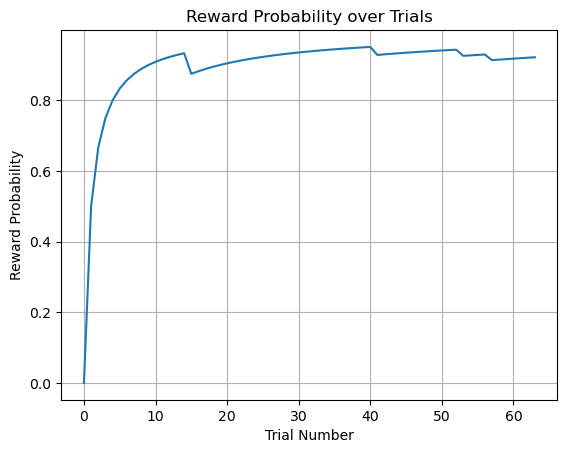

In [607]:
#y = np.cumsum(poke_and_reward_table['reward_state'] / 64).tolist()
y = get_reward_probability(poke_and_reward_table['reward_state'])
x = list(range(0,len(poke_and_reward_table)))
plt.title('Reward Probability over Trials')
plt.ylabel('Reward Probability')
plt.xlabel('Trial Number')
plt.grid(True)
plt.plot(x,y)
plt.show()

In [ ]:
list(range(0,len(poke_and_reward_table)))